<a href="https://colab.research.google.com/github/Amelrich/Capstone-Fall-2020/blob/master/romane_fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install tslearn

In [4]:
!pip install -U yellowbrick

     |████████████████████████████████| 276kB 3.4MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from scipy.fftpack import fft,ifft
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [7]:
class TS_generator:
  def __init__(self, nb_timeseries=2000, chunk_size=100):
    
    self.chunk_size = chunk_size
    self.nb_timeseries = nb_timeseries

    #Retrieve the stocks names
    self.symbols = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/master/sp500.csv', index_col=False)
    self.symbols = list(self.symbols['Symbol'].values)
    self.symbols = ['BF-B' if x=='BF.B' else x for x in self.symbols]
    self.symbols = ['BRK-B' if x=='BRK.B' else x for x in self.symbols]

    self.list_df = []

    #Build the random time series
    self.build_()

  def build_(self):    
    for _ in range(self.nb_timeseries):

      #Pick a random stock
      stock = self.symbols[np.random.randint(len(self.symbols))]
      TS = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/master/data/'+stock+'.csv')
      
      #Pick a random starting point
      timemax = len(TS) - self.chunk_size
      start = np.random.randint(timemax)
      stock_df = TS[start : start+self.chunk_size]

      self.list_df.append( stock_df )

  def get_list_of_df(self):
    #
    return self.list_df

  def get_array(self):
    #Return adjusted close array
    close_array = np.zeros((self.nb_timeseries, self.chunk_size))

    for i in range(self.nb_timeseries):
      close_array[i,:] = self.list_df[i]['Adj Close'].to_numpy()

    return close_array

In [8]:
nb_timeseries = 2000

gen = TS_generator(nb_timeseries=nb_timeseries, chunk_size=100) #default values but just for the syntax
X = gen.get_array()

In [9]:
#Apply MinMax Scaling
X_scaled = MinMaxScaler().fit_transform(X.T).T

#Apply Fourier Transform for test
X_ft = fft(X_scaled)
print(X_ft[0][:10]) #first 10 coefficients

[49.29881629 -0.j          0.89910922+12.78305323j
  2.35518948+11.07079614j -1.67223551 +3.69688038j
 -0.28680827 +4.27460481j -0.85066058 +0.42455275j
  0.43412177 +2.44367736j  1.39583347 +2.25617504j
 -1.24496506 -0.12624891j -0.73219052 +2.21312339j]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


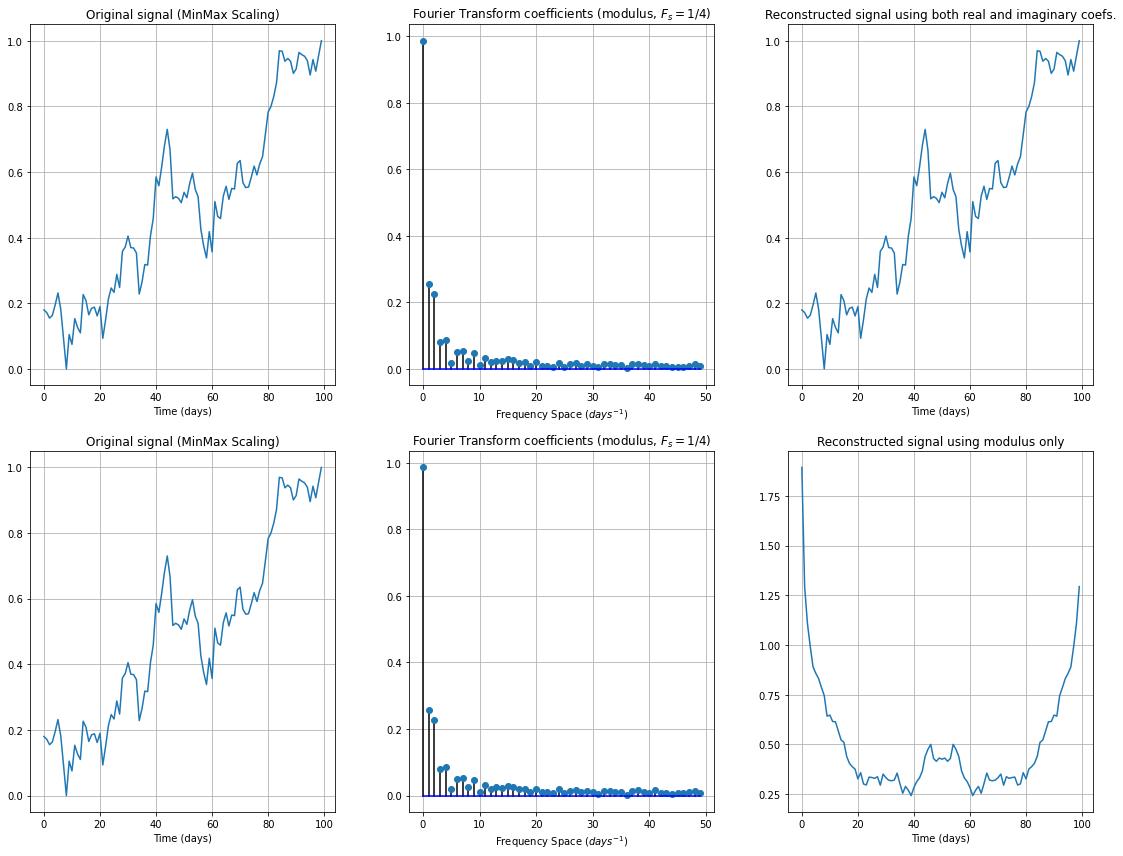

In [10]:
#First approach: Use modulus only
i=0
j=2

# sampling rate: f_max /2 - let's say the smallest pattern is 2 days
Fs = 1/4 
n = X_scaled.shape[1]
fr = Fs/2 * np.linspace(0,1,n//2)
X_ft_mod = 2/n * abs(X_ft)[:,0:np.size(fr)]

X_ft_reconstructed = ifft(abs(X_ft)).real
X_ft_complex_reconstructured = ifft(X_ft)

fig, axes = plt.subplots(2,3,figsize=(16,12))

axes[0,0].plot(X_scaled[i])
axes[0,0].set_xlabel('Time (days)')
axes[0,0].set_title('Original signal (MinMax Scaling)')
axes[0,0].grid()

axes[0,1].set_title('Fourier Transform coefficients (modulus, $F_s = 1/4 $)')
axes[0,1].stem(X_ft_mod[i],linefmt='k',basefmt='b')
axes[0,1].set_xlabel('Frequency Space ($days^{-1}$)')
axes[0,1].grid()

axes[0,2].plot(X_ft_complex_reconstructured[i])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[0,2].set_title('Reconstructed signal using both real and imaginary coefs.')
axes[0,2].set_xlabel('Time (days)')
axes[0,2].grid()

axes[1,0].plot(X_scaled[i])
axes[1,0].set_xlabel('Time (days)')
axes[1,0].set_title('Original signal (MinMax Scaling)')
axes[1,0].grid()

axes[1,1].set_title('Fourier Transform coefficients (modulus, $F_s = 1/4 $)')
axes[1,1].stem(X_ft_mod[i],linefmt='k',basefmt='b')
axes[1,1].set_xlabel('Frequency Space ($days^{-1}$)')
axes[1,1].grid()

axes[1,2].plot(X_ft_reconstructed[i])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[1,2].set_title('Reconstructed signal using modulus only')
axes[1,2].set_xlabel('Time (days)')
axes[1,2].grid()

plt.tight_layout()
plt.show()

## 1. Concatenate Imaginary and Real Parts

In [11]:
#real/imaginary concat
X_ft_subs_ri = []

for i in X_ft:
    X_ft_subs_ri.append(i[1:12])

X_ft_subs_ri = np.array(X_ft_subs_ri)
X_ft_subs_ri = np.concatenate((X_ft_subs_ri.real,X_ft_subs_ri.imag),axis=1)

X_ft_subs_ri[:5]

array([[ 0.89910922,  2.35518948, -1.67223551, -0.28680827, -0.85066058,
         0.43412177,  1.39583347, -1.24496506, -0.73219052, -0.60439702,
        -0.59147376, 12.78305323, 11.07079614,  3.69688038,  4.27460481,
         0.42455275,  2.44367736,  2.25617504, -0.12624891,  2.21312339,
         0.07442775,  1.52253751],
       [ 3.66360531, -1.62345306,  3.74784297, -3.47869467, -2.06351147,
        -0.89080859, -0.89636069,  0.02814384,  0.72910106,  0.65901463,
        -0.7101375 ,  4.7414552 ,  7.34463449,  6.13712306,  5.23122801,
         3.94405982,  2.53244475,  1.68867312,  1.71392269,  2.07083814,
         2.49662868,  0.7263027 ],
       [ 9.22491219, -2.32362664,  0.75994695,  0.18426556,  0.91355385,
        -3.02306784,  1.27420218, -0.73101949, -1.11068857,  0.30649843,
         1.01473289, 17.82940676,  0.94577648,  1.66530349,  0.44507382,
        -2.74576017,  1.2423374 , -0.02390328,  0.56737022, -1.27095125,
         0.30488364, -0.46289549],
       [11.5660506 

In [12]:
X_ft_subs_ri.shape

(2000, 22)

/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


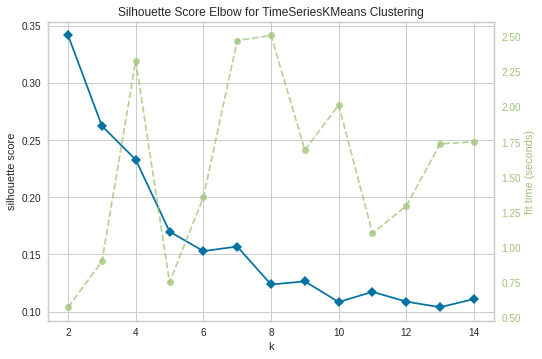

In [13]:
#Find best k
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

model1 = TimeSeriesKMeans()
visualizer = KElbowVisualizer(model1, k=(2,15), metric='silhouette')

visualizer.fit(X_ft_subs_ri)        # Fit the data to the visualizer
visualizer.show();

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


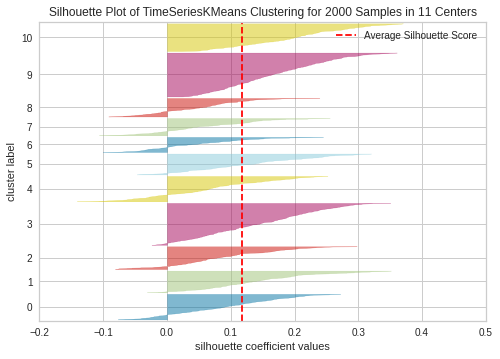

In [14]:
#silhouette scores for each cluster for best k
model1 = TimeSeriesKMeans(n_clusters=11)
visualizer = SilhouetteVisualizer(model1, colors='yellowbrick')
visualizer.fit(X_ft_subs_ri) 
visualizer.show()

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


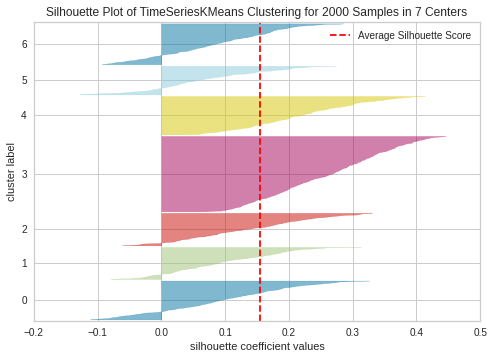

In [15]:
model_ri = TimeSeriesKMeans(n_clusters=7)
visualizer_ri = SilhouetteVisualizer(model_ri, colors='yellowbrick')
visualizer_ri.fit(X_ft_subs_ri) 
visualizer_ri.show()

## 2. Module

In [16]:
#taking only the modulus
X_ft_subs = []

for i in X_ft:
  X_ft_subs.append(i[1:13])

X_ft_subs = np.array(X_ft_subs)
X_ft_subs = X_ft_subs.real
X_ft_subs[:10]

array([[ 8.99109217e-01,  2.35518948e+00, -1.67223551e+00,
        -2.86808265e-01, -8.50660577e-01,  4.34121770e-01,
         1.39583347e+00, -1.24496506e+00, -7.32190524e-01,
        -6.04397021e-01, -5.91473763e-01, -6.92691911e-01],
       [ 3.66360531e+00, -1.62345306e+00,  3.74784297e+00,
        -3.47869467e+00, -2.06351147e+00, -8.90808590e-01,
        -8.96360687e-01,  2.81438424e-02,  7.29101061e-01,
         6.59014634e-01, -7.10137496e-01, -3.18482015e-01],
       [ 9.22491219e+00, -2.32362664e+00,  7.59946947e-01,
         1.84265560e-01,  9.13553851e-01, -3.02306784e+00,
         1.27420218e+00, -7.31019493e-01, -1.11068857e+00,
         3.06498429e-01,  1.01473289e+00, -1.02046682e-01],
       [ 1.15660506e+01,  1.23537331e+00, -7.67070939e+00,
         2.37809715e+00, -1.63601672e+00, -6.49396440e-01,
        -1.27718708e+00,  3.64826287e-01,  1.87899090e+00,
        -2.29290425e+00,  6.76667314e-01,  4.53050374e-02],
       [ 7.20929247e+00, -9.06239472e-02, -3.8236064

/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


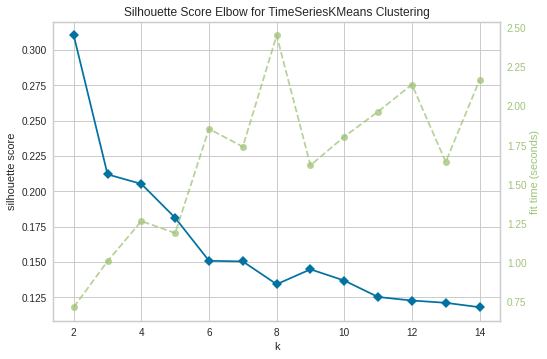

In [17]:
#Find best k
model2 = TimeSeriesKMeans()
visualizer2 = KElbowVisualizer(model2, k=(2,15), metric = 'silhouette')

visualizer2.fit(X_ft_subs)       # Fit the data to the visualizer
visualizer2.show();

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


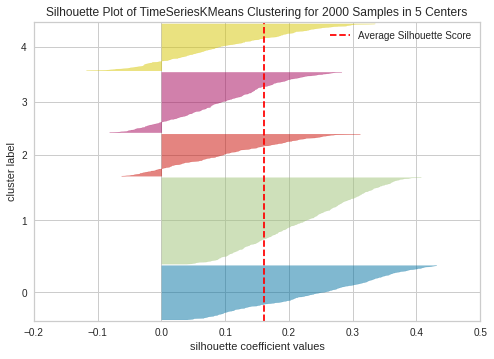

In [18]:
model2 = TimeSeriesKMeans(n_clusters=5)
visualizer2 = SilhouetteVisualizer(model2, colors='yellowbrick')
visualizer2.fit(X_ft_subs_ri) 
visualizer2.show()   

## 3. Optimization of the number of coefficient

### 3.1 Imaginary + real

2 to 3 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


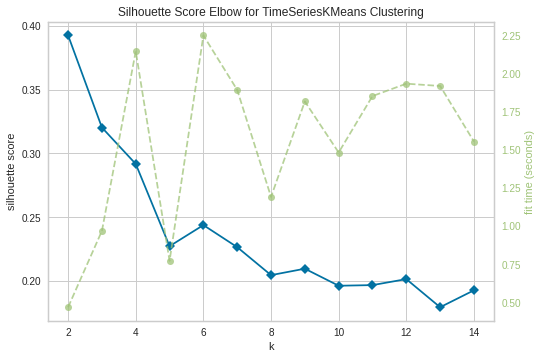

2 to 4 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


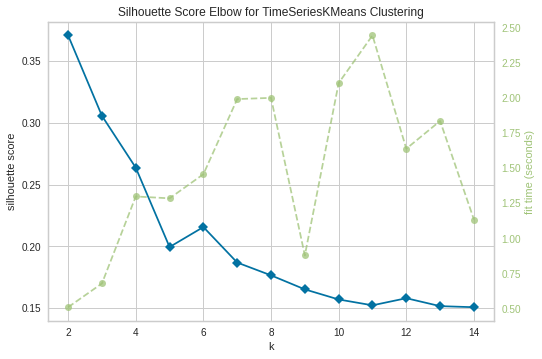

2 to 5 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


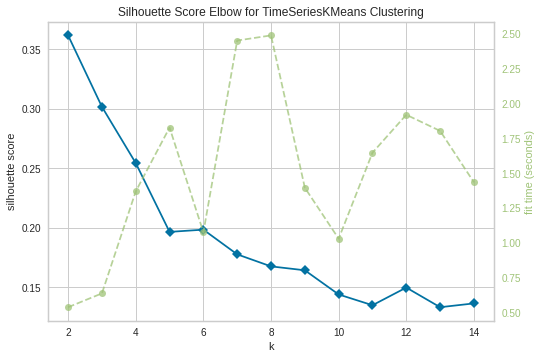

2 to 6 coefficients


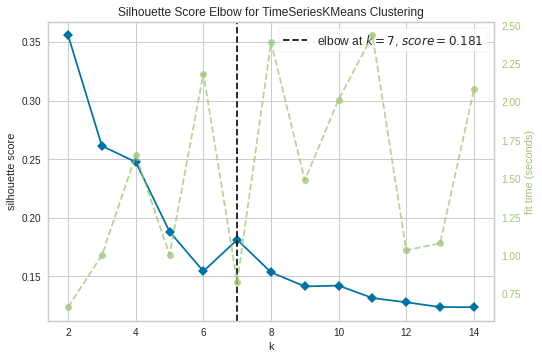

2 to 7 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


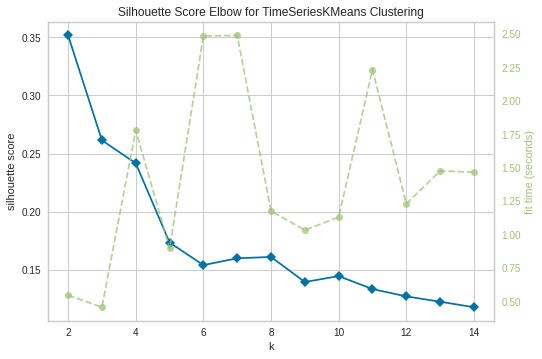

2 to 8 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


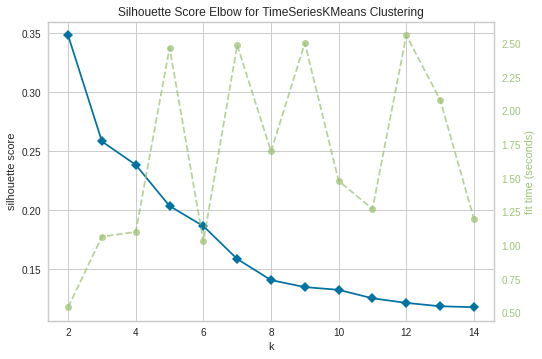

2 to 9 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


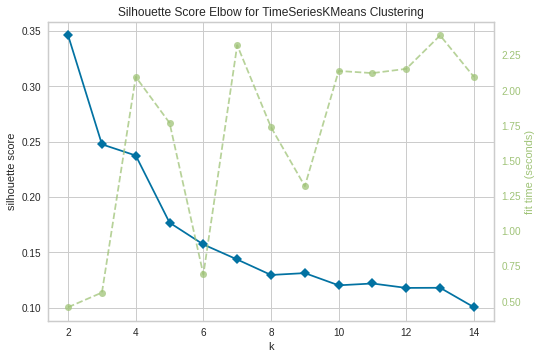

2 to 10 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


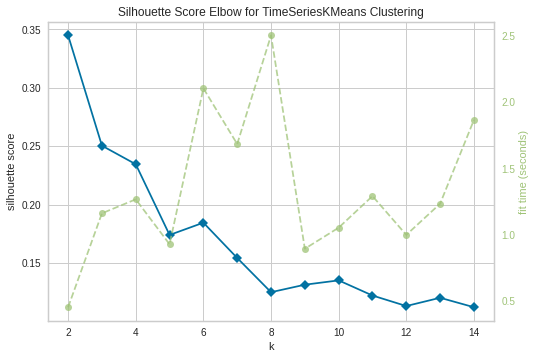

2 to 11 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


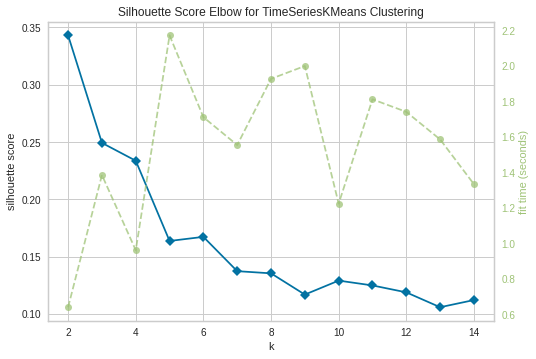

2 to 12 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


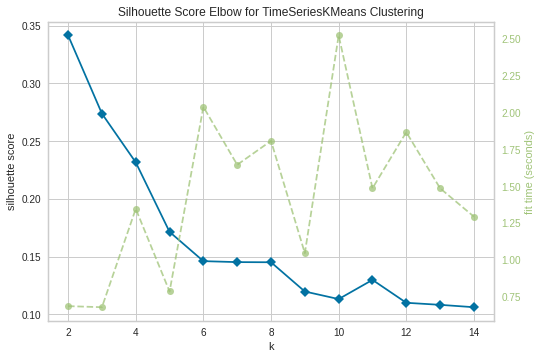

2 to 13 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


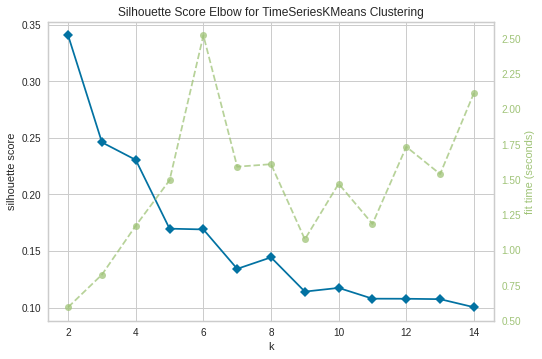

In [19]:
for j in range(3,14):

  X_ft_subs_ri = []

  for i in X_ft:
    X_ft_subs_ri.append(i[1:j])

  X_ft_subs_ri = np.array(X_ft_subs_ri)
  X_ft_subs_ri = np.concatenate((X_ft_subs_ri.real,X_ft_subs_ri.imag),axis=1)

  model_ri_best = TimeSeriesKMeans()
  visualizer_ri_best = KElbowVisualizer(model_ri_best, k=(2,15), metric = 'silhouette')

  print('2 to', j, 'coefficients')
  visualizer_ri_best.fit(X_ft_subs_ri)       # Fit the data to the visualizer
  visualizer_ri_best.show();



###  3.1 (cont.) Amaury's method for optimal number of coefficients (imaginary+real)

2 to 3 coefficients
5


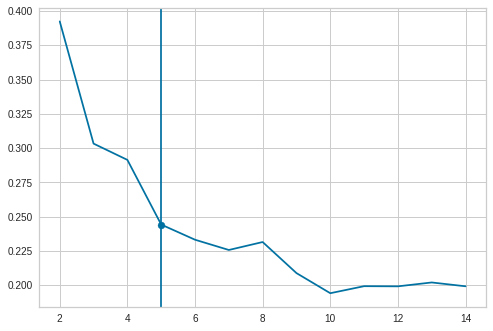

2 to 4 coefficients
5


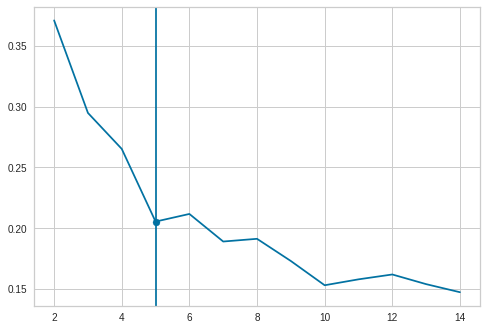

2 to 5 coefficients
5


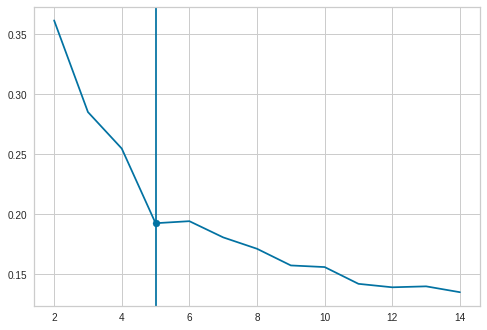

2 to 6 coefficients
5


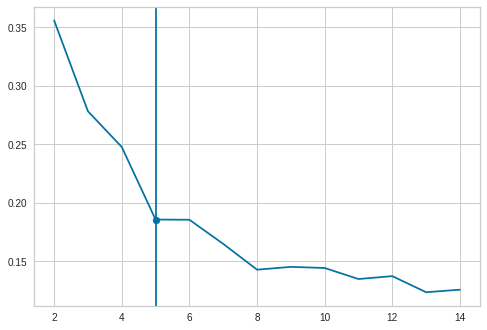

2 to 7 coefficients
5


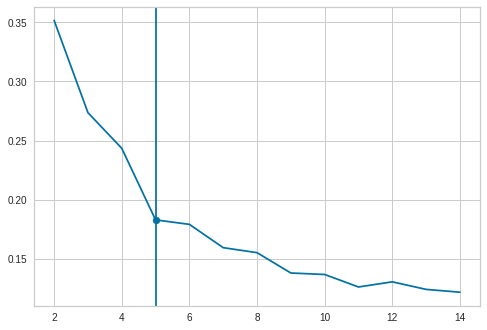

2 to 8 coefficients
5


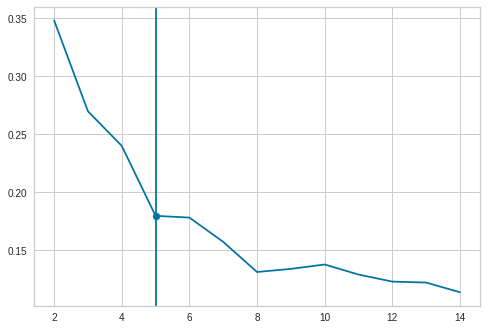

2 to 9 coefficients
5


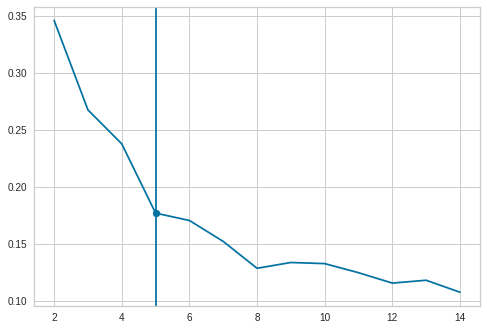

2 to 10 coefficients
5


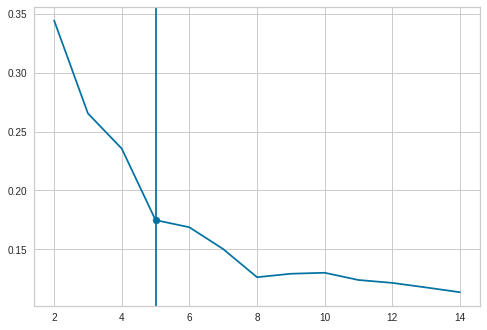

2 to 11 coefficients
5


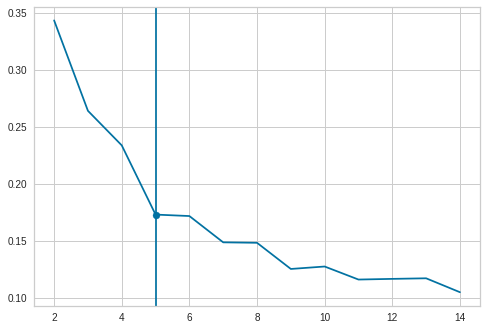

2 to 12 coefficients
5


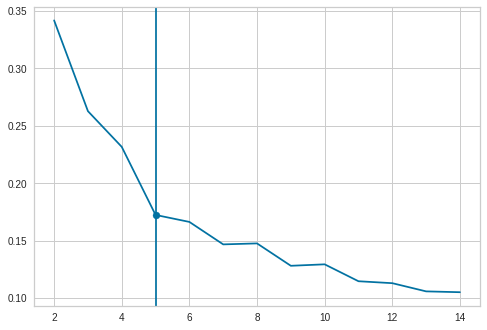

2 to 13 coefficients
8


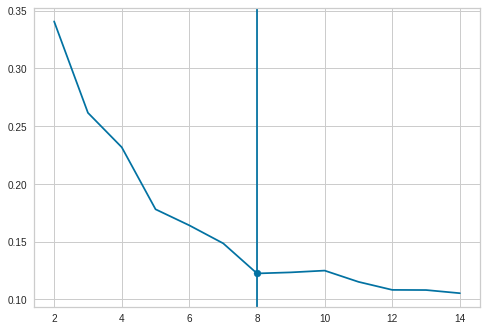

In [20]:
#Max & Romane
def elbow(score_tab):
    a = (score_tab[-1] - score_tab[0]) / len(score_tab)
    b = score_tab[0]
    elb_tab = [ np.abs(score_tab[i] - a*i - b) / np.sqrt(a*a + 1) for i in range(len(score_tab)) ]
    return elb_tab.index(max(elb_tab))  


for j in range(3,14):
    #using fewer coefficients != setting coefficients to zero
    X_ft_subs_ri = X_ft[:,1:j].copy()
    print('2 to', j, 'coefficients')
    X_ft_subs_ri = np.concatenate((X_ft_subs_ri.real,X_ft_subs_ri.imag),axis=1)
    silhouette_scores = []
    for k in range(2,15):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_ft_subs_ri)
        X_ft_subs_ri_assignments = kmeans.predict(X_ft_subs_ri)
        silhouette_scores.append(silhouette_score(X_ft_subs_ri,X_ft_subs_ri_assignments))
    opt_k = elbow(silhouette_scores) + 2 #k starts at 2 (whereas the first index from Amaury's method is 0)
    print(opt_k)
    plt.figure()
    plt.plot(range(2,15),silhouette_scores)
    plt.axvline(x=opt_k)
    plt.scatter([opt_k],[silhouette_scores[opt_k-2]]) #the first value in silhouette_scores corresponds to k=2
    plt.show()


### 3.2 Using only real coefficients

2 to 3 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


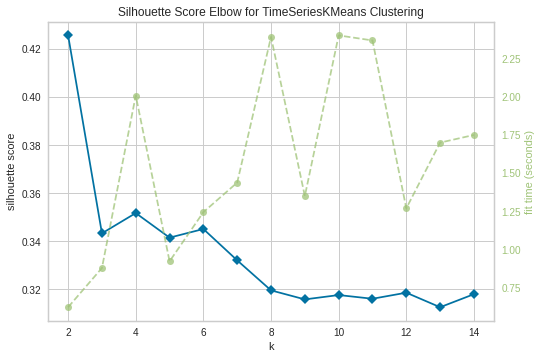

2 to 4 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


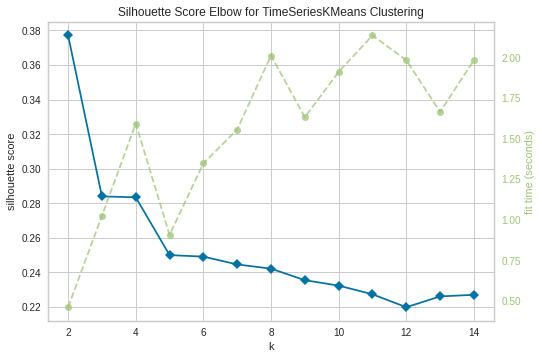

2 to 5 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


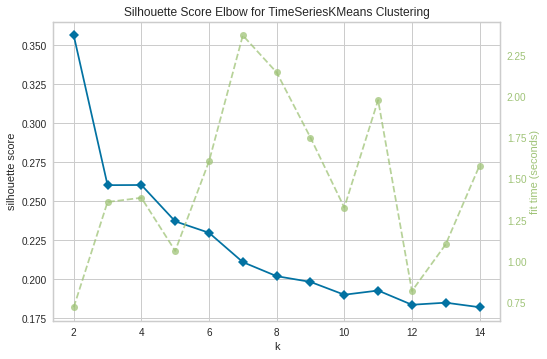

2 to 6 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


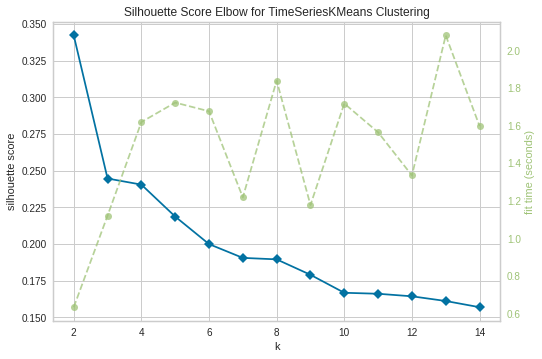

2 to 7 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


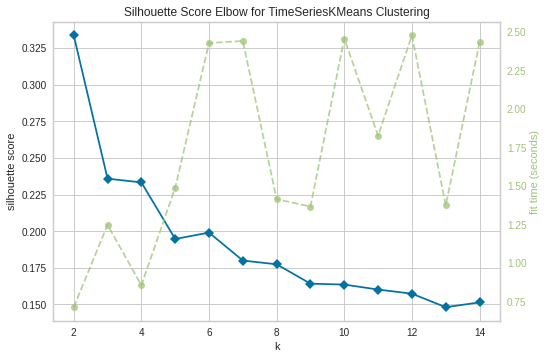

2 to 8 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


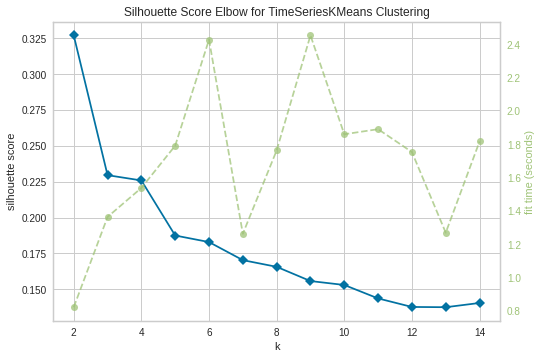

2 to 9 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


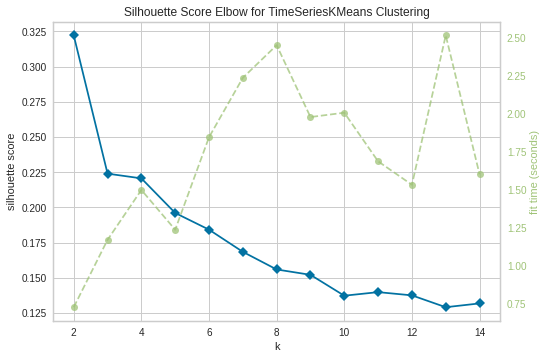

2 to 10 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


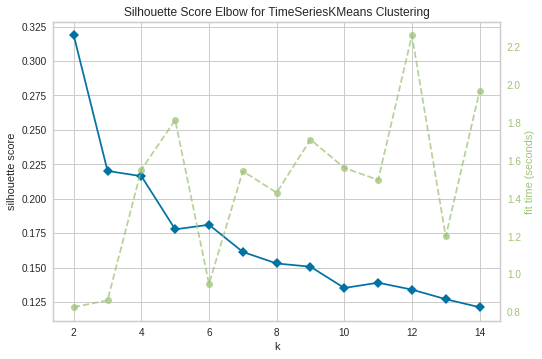

2 to 11 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


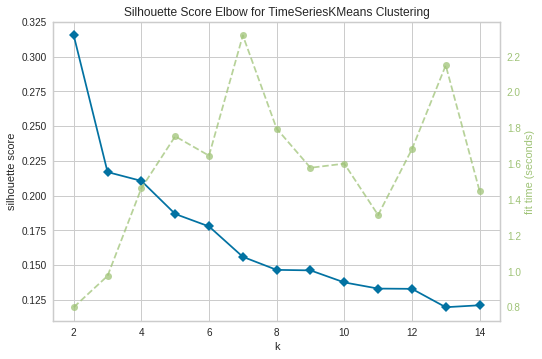

2 to 12 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


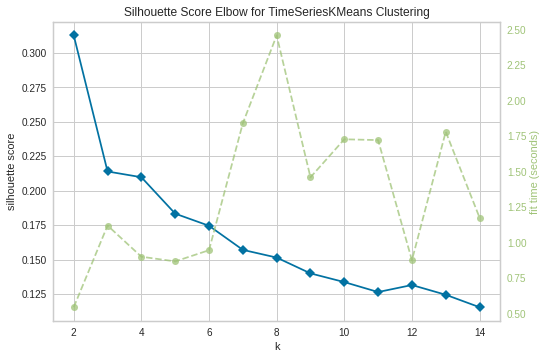

2 to 13 coefficients


/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


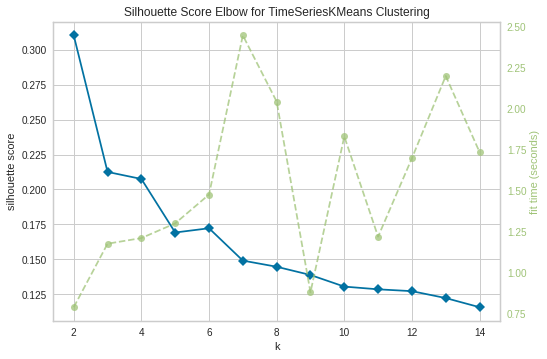

In [21]:
for j in range(3,14):

    X_ft_subs = []

    for i in X_ft:
        X_ft_subs.append(i[1:j])

    X_ft_subs = np.array(X_ft_subs)
    X_ft_subs = X_ft_subs.real
    X_ft_subs[:10]

    model_subs_best = TimeSeriesKMeans()
    visualizer_subs_best = KElbowVisualizer(model_subs_best, k=(2,15), metric = 'silhouette')

    print('2 to', j, 'coefficients')
    visualizer_subs_best.fit(X_ft_subs)       # Fit the data to the visualizer
    visualizer_subs_best.show();



### 3.2 Amaury's method (using only real coefficients)

2 to 3 coefficients
[0.42565804805402874, 0.3432568837613326, 0.3549054900973652, 0.34285659142112307, 0.3450300351767094, 0.3317070188722988, 0.3268156188355376, 0.3234347132022921, 0.3161784597844574, 0.31879937505558154, 0.3103456056923222, 0.31918388483835974, 0.32161982712871007]
3


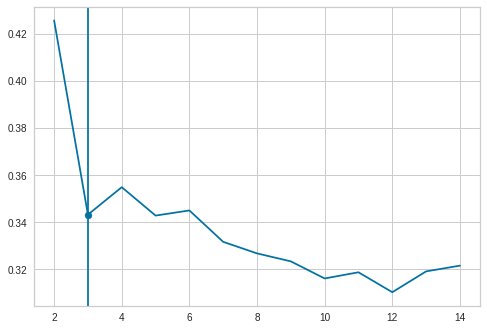

2 to 4 coefficients
[0.37713328355391584, 0.2838803652345308, 0.2865594713505213, 0.26739582737857204, 0.2611743368910436, 0.24505618129125564, 0.23714532235555935, 0.23659598696585868, 0.23638967629378088, 0.2321837514751611, 0.23222903418326124, 0.22378082368557822, 0.22649673777624446]
3


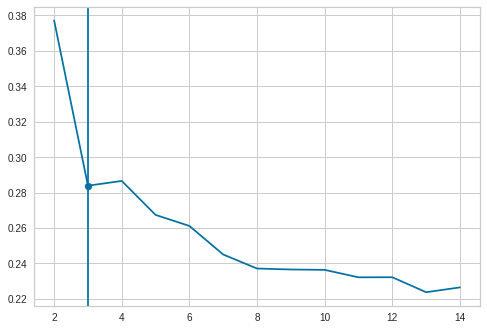

2 to 5 coefficients
[0.35620754272608035, 0.26033583684892836, 0.2600425927841384, 0.2377241754633873, 0.23000329659490115, 0.21158165811912608, 0.20211747020634818, 0.201453295524223, 0.19803133389872046, 0.19248806415272549, 0.18891170899513868, 0.181667459035869, 0.18805314220996114]
3


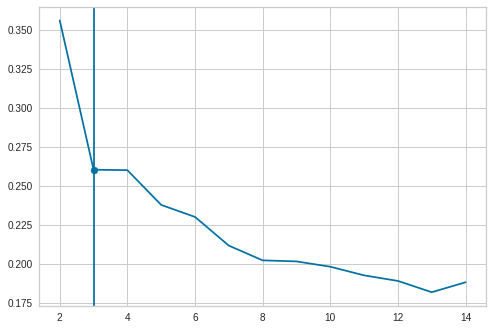

2 to 6 coefficients
[0.34184768470185917, 0.24450832376017223, 0.24330739018954517, 0.21779832598540888, 0.2098316585299512, 0.19063802508070826, 0.18205382589148325, 0.17821949566859532, 0.16983554889024538, 0.1726492870785064, 0.1678129133183302, 0.16220614835495753, 0.1619230602873281]
3


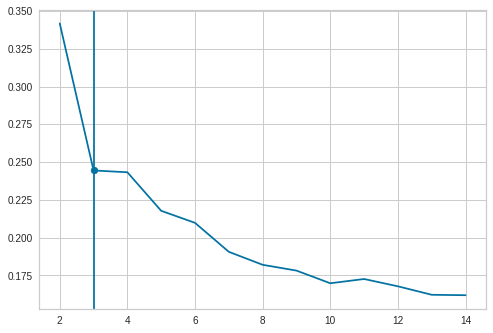

2 to 7 coefficients
[0.33371974190842285, 0.23580724056277336, 0.23372117764075323, 0.20884155246758945, 0.19938571410563014, 0.17981306635798114, 0.1705145812368901, 0.1662114893950009, 0.16242591582613866, 0.15725170086771867, 0.15736703999132173, 0.1511589501956738, 0.1525678836447603]
7


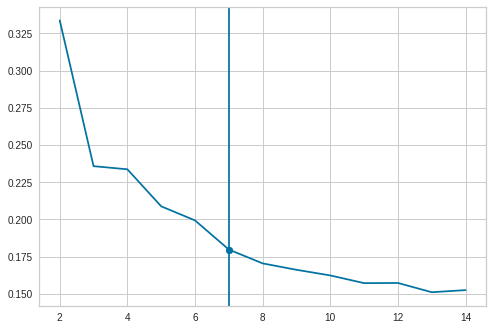

2 to 8 coefficients
[0.3269990477104003, 0.22882322738454047, 0.22608111230744243, 0.20076149035898794, 0.19095299948191127, 0.17135001249473356, 0.16434167224853152, 0.15942447881746366, 0.15461924426352805, 0.1525925345320412, 0.14735300420583497, 0.1454597204274196, 0.14080573863278298]
7


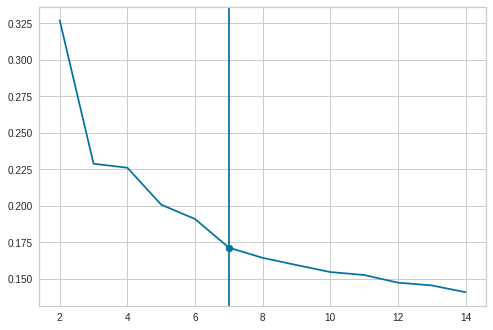

2 to 9 coefficients
[0.3220771989926447, 0.2239331202550855, 0.22058256817428493, 0.19627972759289458, 0.18629556316631324, 0.16559582374298082, 0.15653445922389758, 0.15234906204044577, 0.14762299156453604, 0.14678840110642857, 0.13997996518425648, 0.13734248693148998, 0.13457821973579706]
7


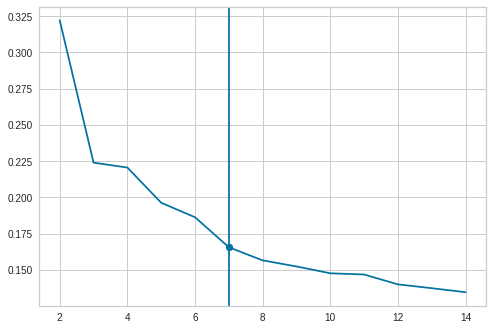

2 to 10 coefficients
[0.3184091172367122, 0.22010315132551306, 0.21632224627589391, 0.19184133113903584, 0.18141852544091308, 0.16126730633331665, 0.1523408463869272, 0.14976822411249832, 0.1438334517508665, 0.13860356868271434, 0.13590701852038695, 0.13015604651057328, 0.12818938516347975]
7


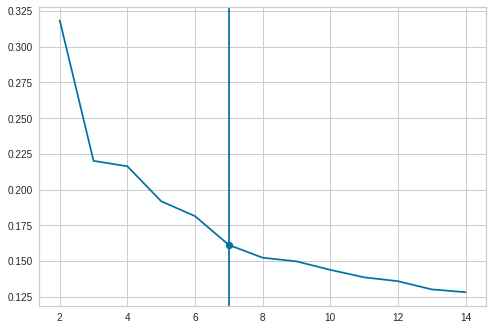

2 to 11 coefficients
[0.3151555286276287, 0.2169748241393693, 0.21291832172810263, 0.18717375607756687, 0.17749644688032648, 0.1583180559926447, 0.14881474821281573, 0.14501382559465492, 0.14090745838658578, 0.13768926308241078, 0.132410050646859, 0.1253780401667773, 0.12203472417398213]
5


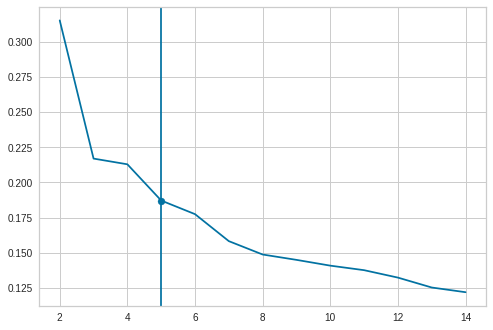

2 to 12 coefficients
[0.3124836333243806, 0.21403828165917446, 0.2095845657147129, 0.1846707087778027, 0.1743937037042048, 0.1545020931269371, 0.14595130968561149, 0.14290158658995802, 0.13911296949149357, 0.1319945377589357, 0.1281462409828604, 0.12266023780027556, 0.127136984038065]
7


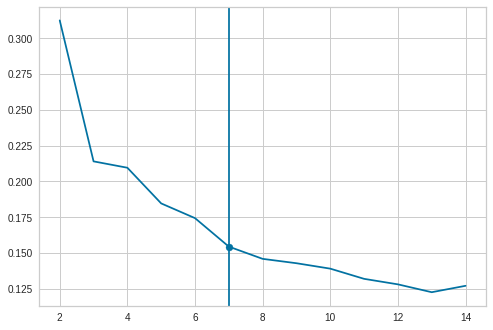

2 to 13 coefficients
[0.3103082205380473, 0.2119100426781737, 0.2074272084088464, 0.18159822091981614, 0.17195018109790364, 0.15307172470202368, 0.1437709896952469, 0.1404792810768509, 0.1364480948151896, 0.13174761846565042, 0.12471712258581485, 0.11930193387343727, 0.12210929108507007]
5


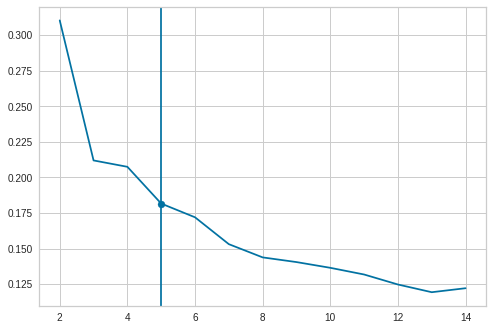

In [25]:
#Max & Romane
for j in range(3,14):
    #using fewer coefficients != setting coefficients to zero
    X_ft_subs_ri = X_ft[:,1:j].copy()
    X_ft_subs_ri = X_ft_subs_ri.real
    print('2 to', j, 'coefficients')
    silhouette_scores = []
    for k in range(2,15):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_ft_subs_ri)
        X_ft_subs_ri_assignments = kmeans.predict(X_ft_subs_ri)
        silhouette_scores.append(silhouette_score(X_ft_subs_ri,X_ft_subs_ri_assignments))
    print(silhouette_scores)
    opt_k = elbow(silhouette_scores) + 2 #k starts at 2 (whereas the first index from Amaury's method is 0)
    print(opt_k)
    plt.figure()
    plt.plot(range(2,15),silhouette_scores)
    plt.axvline(x=opt_k)
    plt.scatter([opt_k],[silhouette_scores[opt_k-2]]) #the first value in silhouette_scores corresponds to k=2
    plt.show()

In [30]:
y = [0.3432568837613326,0.2838803652345308,0.26033583684892836,0.24450832376017223,0.17981306635798114,0.17135001249473356,0.16559582374298082,0.16126730633331665,0.18717375607756687,0.1545020931269371,0.18159822091981614]
x = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

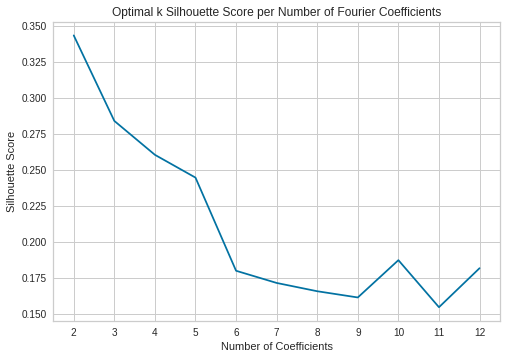

In [35]:
plt.plot(x, y)
plt.title('Optimal k Silhouette Score per Number of Fourier Coefficients')
plt.xlabel('Number of Coefficients')
plt.xticks(np.arange(2, 13))
plt.ylabel('Silhouette Score')
plt.show()